## Introduction to Colab and the GPU

### Step 1: Get the data and load it to your Google Drive

Get the file [DogsCatsSmall.tar.gz](http://zacharski.org/files/courses/cs370/dogsCatsSmall.tar.gz), uncompress it, save it on your Google Drive. (Delete .DS_Store from train, train/dogs and train/cats)

### Step 2: Enable GPU Support
Under the `Edit` menu, select `Notebook settings` Under Hardware Accelerator select GPU

Test it with the following code


In [16]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

You should see

    /device:GPU:0
    
    
### Step 3: Link Your Google Drive to the Notebook

Execute the following:

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

now mount your Google Drive

In [ ]:
!mkdir -p drive
!google-drive-ocamlfuse drive

You only need to do the above once.

Now let's test it to see if the notebook can reach the data (change the path to match yours):

In [22]:
!ls drive/BigData/cats_and_dogs_small

cats_and_dogs_small_1.h5  test	train  validation


And now let's set up some variables pointing to the training, validation, and test directories

In [24]:
import os
base_dir = "drive/BigData/cats_and_dogs_small"

train_dir = os.path.join(base_dir, 'train')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_dir = os.path.join(base_dir, 'validation')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
test_dir = os.path.join(base_dir, 'test')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')


print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


## Data Preprocessing
Use the same data preprocessing steps we used for the original Dogs n' Cats. You should create a train_generator and a validation_generator.

In [25]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
test2_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=5,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=5,
        class_mode='binary')

test_generator = test2_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=5,
        class_mode='binary')

Using TensorFlow backend.


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Building a ConvNet Model
We've already built a small convnet for MNIST in the previous example, so you should be familiar with them. We will reuse the same general structure: our convnet will be a stack of alternated Conv2D (with relu activation) and MaxPooling2D layers. Here are the steps we would like to do:

1. Create a sequential model
2. Add a Conv2D layer. Use 3x3 patches and a depth of 32. The input with be 150 x 150 pixel RGB images (depth of 3)
3. Add a MaxPooling2D with a patch size of 2 x 2.
4. Add another Conv2D layer. Use 3x3 patches and a depth of 64.
5. Add a MaxPooling2D with a patch size of 2 x 2.
6. Add another Conv2D layer. Use 3x3 patches and a depth of 128.
7. Add a MaxPooling2D with a patch size of 2 x 2.
8. Add another Conv2D layer. Use 3x3 patches and a depth of 128.
9. Add a MaxPooling2D with a patch size of 2 x 2.
10. Finish up by flattening and adding a dense layer


In [ ]:

from keras import layers
from keras import models

# ADD YOUR CODE HERE    
# model = ...


### Verify that we did it right. 
Let's check by using the summary method:

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

You should see:
    
    
		_________________________________________________________________
		Layer (type)                 Output Shape              Param #   
		=================================================================
		conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
		_________________________________________________________________
		max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
		_________________________________________________________________
		conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
		_________________________________________________________________
		max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
		_________________________________________________________________
		conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
		_________________________________________________________________
		max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
		_________________________________________________________________
		conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
		_________________________________________________________________
		max_pooling2d_4 (MaxPooling2 (None, 7, 7, 128)         0         
		_________________________________________________________________
		flatten_1 (Flatten)          (None, 6272)              0         
		_________________________________________________________________
		dense_1 (Dense)              (None, 512)               3211776   
		_________________________________________________________________
		dense_2 (Dense)              (None, 1)                 513       
		=================================================================
		Total params: 3,453,121
		Trainable params: 3,453,121
		Non-trainable params: 0
        
# Compile the Model

Set the parameters:

* set loss to be binary_crossentropy
* use `optimizers.RMSprop(lr=1e-4)` as the optimizer
* for metrics use `acc`


## Fit the model
Use `fit_generator`. Don't forget to save the history.

1. Use 5 epochs
2. Each with 30 steps
3. Use the `validation_generator` as the validation data
4. Set the validation steps to 15.


Epoch 1/5
30/30 [==============================] - 114s 4s/step - loss: 0.7658 - acc: 0.4733 - val_loss: 0.7070 - val_acc: 0.4933
Epoch 2/5
30/30 [==============================] - 53s 2s/step - loss: 0.6993 - acc: 0.5333 - val_loss: 0.7139 - val_acc: 0.5067
Epoch 3/5
30/30 [==============================] - 91s 3s/step - loss: 0.6990 - acc: 0.5400 - val_loss: 0.6885 - val_acc: 0.5067
Epoch 4/5
30/30 [==============================] - 88s 3s/step - loss: 0.6982 - acc: 0.4933 - val_loss: 0.6885 - val_acc: 0.6133
Epoch 5/5
30/30 [==============================] - 80s 3s/step - loss: 0.6905 - acc: 0.5467 - val_loss: 0.6819 - val_acc: 0.5067


It's a good practice to save our model

In [ ]:
# Change the path
model.save('drive/BigData/cats_and_dogs_small/cats_and_dogs_small_1.h5')

Let's plot the loss and accuracy:

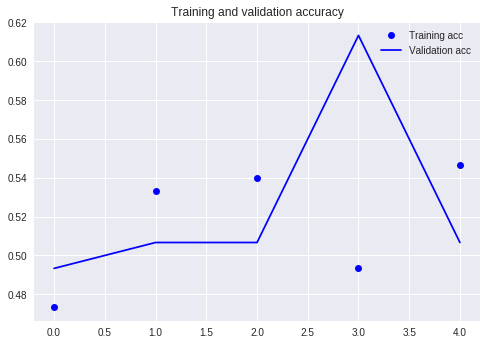

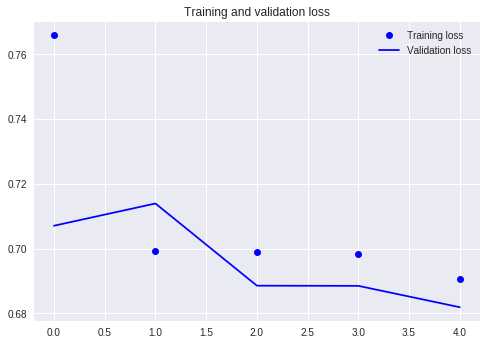

In [30]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Determining our Accuracy on the Test Data

In [32]:
test_loss, test_acc = model.evaluate_generator(test_generator, 100)
print('test_acc:', test_acc)

test_acc: 0.49800001189112664


Hmmm. That's a drag. All that work and we are about equal with chance. Let's see if we can improve it.

# Using data augmentation

This section is directly from François Chollet 

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same picture twice. This helps the model get exposed to more aspects of the data and generalize better.
In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our ImageDataGenerator instance. Let's get started with an example:



In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal 
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

444
807


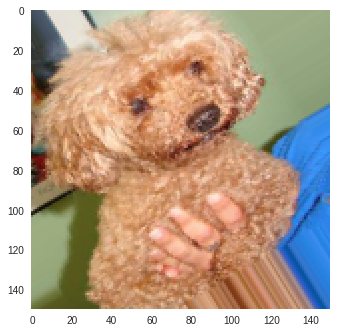

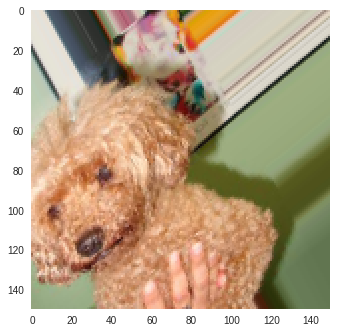

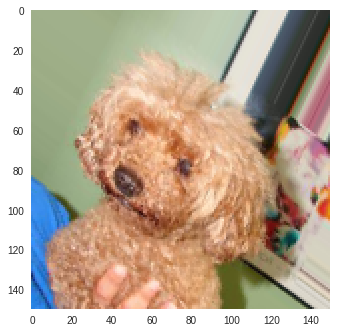

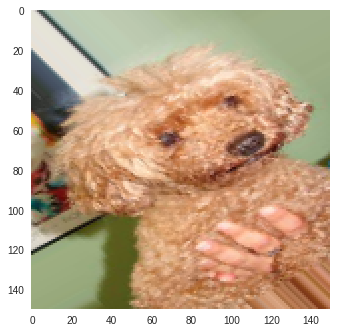

In [35]:
import matplotlib.pyplot as plt 
import os
train_dogs_dir = train_dir + '/dogs'
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_dogs_dir, fname) for fname in os.listdir(train_dogs_dir)]

# We pick one image to "augment"
print(os.listdir(train_dogs_dir).index('dog.905.jpg'))
print(os.listdir(train_dogs_dir).index('dog.788.jpg'))
img_path = fnames[807]
# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0

for batch in datagen.flow(x, batch_size=1):
    ax = plt.gca()
    ax.grid(False)
    plt.figure(i)
   
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
ax = plt.gca()
ax.grid(False)
plt.show()

### For fun
Find a dog or cat picture you like and perform augmentation on it. I perused my dogs directory and liked `dogs.788.jpg`. A sensible thing would be to hard-code that picture in the above code, but I used the commented out line to find the index of that image and plugged that index number into the code. (François Chollet had originally --gasp -- a cat picture! Imagine that) I am hoping this will help you understand the code a bit more.

444
807


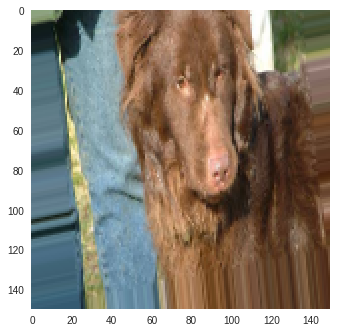

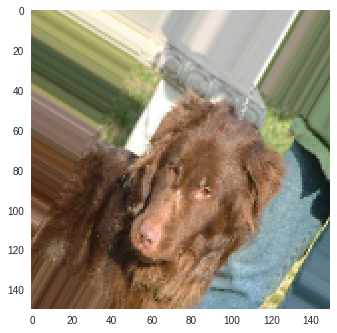

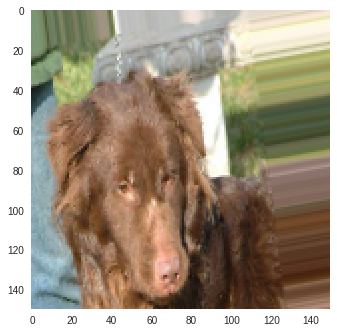

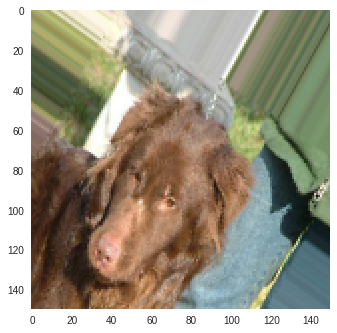

In [36]:
import matplotlib.pyplot as plt 
import os
train_dogs_dir = train_dir + '/dogs'
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_dogs_dir, fname) for fname in os.listdir(train_dogs_dir)]

# We pick one image to "augment"
print(os.listdir(train_dogs_dir).index('dog.905.jpg'))
print(os.listdir(train_dogs_dir).index('dog.788.jpg'))
img_path = fnames[444]
# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0

for batch in datagen.flow(x, batch_size=1):
    ax = plt.gca()
    ax.grid(False)
    plt.figure(i)
   
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
ax = plt.gca()
ax.grid(False)
plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs 
that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, 
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight 
overfitting, we will also add a Dropout layer to our model using: 

     augmented_model.add(layers.Dropout(0.3))

between the flatten layer and the densely-connected classifier. Copy your model declaration from above and add this line.

In [ ]:
from keras import layers
from keras import models


# TO BE DONE

Sweet! Here is the code for the augmented data generator:

In [38]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=10,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=10,
        class_mode='binary')




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Compile and Fit the model
Now we will use these new generators to fit the model.

Use `fit_generator`. Don't forget to save the history.



Epoch 1/5
30/30 [==============================] - 176s 6s/step - loss: 0.6989 - acc: 0.4867 - val_loss: 0.6922 - val_acc: 0.5000
Epoch 2/5
30/30 [==============================] - 60s 2s/step - loss: 0.6907 - acc: 0.5300 - val_loss: 0.6942 - val_acc: 0.5000
Epoch 3/5
30/30 [==============================] - 84s 3s/step - loss: 0.6888 - acc: 0.4733 - val_loss: 0.6897 - val_acc: 0.5067
Epoch 4/5
30/30 [==============================] - 89s 3s/step - loss: 0.6885 - acc: 0.5200 - val_loss: 0.6822 - val_acc: 0.5667
Epoch 5/5
30/30 [==============================] - 93s 3s/step - loss: 0.6941 - acc: 0.5233 - val_loss: 0.6833 - val_acc: 0.5000


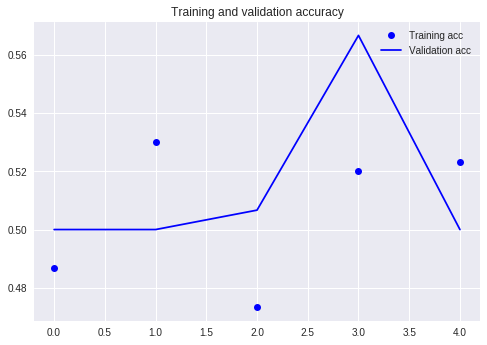

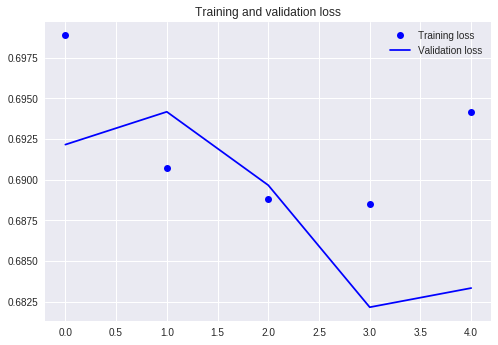

In [41]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Compute the accuracy on the test data

In [42]:
test_loss, test_acc = augmented_model.evaluate_generator(test_generator, 100)
print('test_acc:', test_acc)

test_acc: 0.50000001257658


# Challenge

Can you get better accuracy on the test data?

## xp = accuracy * 2